In [1]:
from ROOT import TH1F, TCanvas, gStyle, TLegend, TGraph
from sklearn.externals import joblib
from array import array
import pickle
from scipy.stats import ks_2samp
import numpy as np
import datetime
import math
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import LocallyConnected1D
from keras.layers import Conv1D, GlobalMaxPooling1D
from sklearn.preprocessing import StandardScaler
from sklearn.externals import joblib

def prepPlot(_ax, xtitle, ytitle):
    _ax.grid(False)
    _ax.set_xlabel(xtitle)
    _ax.set_ylabel(ytitle)
    _ax.set_title("")

trainFraction = 0.5

print ('Loading signal data file...')
sig_data = joblib.load('../../data/signal_data.p')
print ('Loading background data file...')
bkg_data = joblib.load('../../data/background_data.p')
#
cutIndex = int(trainFraction * len(sig_data))
#
sigTrain = sig_data[: cutIndex]
sigTest = sig_data[cutIndex:]
#
bgTrain = bkg_data[: cutIndex]
bgTest = bkg_data[cutIndex:]

# Create the scaler to preprocess the data
scaler = StandardScaler(copy=True, with_mean=True, with_std=True).fit(sigTrain)

# transform the training sameple
sigTrain = scaler.transform(sigTrain)
# do the same to the test data
sigTest = scaler.transform(sigTest)
# do the same to the test data
bgTrain = scaler.transform(bgTrain)
# do the same to the test data
bgTest = scaler.transform(bgTest)

train = np.append(sigTrain, bgTrain, axis=0)
target = [1] * len(sigTrain) + [0] * len(bgTrain)
test = np.append(sigTest, bgTest, axis=0)
target_test = [1] * len(sigTest) + [0] * len(bgTest)
train = np.expand_dims(train, axis=2)
test = np.expand_dims(test, axis=2)

Using TensorFlow backend.


Loading signal data file...
Loading background data file...


In [2]:
def createKeras(inL):
    model = Sequential()
    model.add(LocallyConnected1D(filters = 90, kernel_size = 2,
                                 activation = 'sigmoid',
                                 input_shape = (inL, 1)))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(30, activation = 'sigmoid'))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(optimizer = 'adam',
                  loss = 'binary_crossentropy'
                  , metrics = ['accuracy'])
    return model

In [3]:
classifier = createKeras(len(train[0]))
classifier.fit(train, target,batch_size=10, epochs=50, validation_data=(test, target_test))

Train on 10000 samples, validate on 10000 samples
Epoch 1/50
10000/10000 [==============================] - 2s 159us/step - loss: 0.4255 - acc: 0.8356 - val_loss: 0.2412 - val_acc: 0.9166

In [4]:
# make outputs
pred = lambda x: classifier.predict_proba(np.expand_dims(x.reshape(1, -1), axis=2))
output_sig_tr = [float(pred(y)[0]) for y in sigTrain][:500]
output_bkg_tr = [float(pred(y)[0]) for y in bgTrain][:500]
output_sig_tst = [float(pred(y)[0]) for y in sigTest][:500]
output_bkg_tst = [float(pred(y)[0]) for y in bgTest][:500]
print (len(output_sig_tr))
print (output_sig_tr[:5])
print (len(output_bkg_tr))
print (output_bkg_tr[:5])

500
[0.9998886585235596, 0.9999867677688599, 0.9970558881759644, 0.9985983967781067, 0.998696506023407]
500
[6.512652907986194e-05, 4.1405658635085274e-07, 1.402222693513977e-07, 7.870663466746919e-06, 0.9342105388641357]


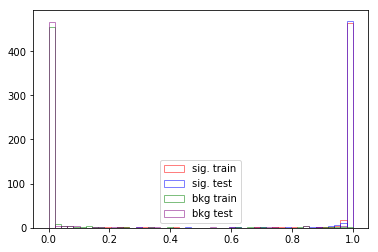

In [5]:
# Plot comparison of the distributions
bins_pr = np.linspace(0, 1, 50)
fig, ax1 = plt.subplots()
plt.clf()
h_sig_train = plt.hist(output_sig_tr, fill=False, edgecolor = 'red', bins = bins_pr, alpha=0.5, label="sig. train")
h_sig_test = plt.hist(output_sig_tst, fill=False, edgecolor = 'blue', bins = bins_pr, alpha=0.5, label="sig. test")
h_bkg_train = plt.hist(output_bkg_tr, edgecolor = 'green', fill=False, bins = bins_pr, alpha=0.5, label="bkg train")
h_bkg_test = plt.hist(output_bkg_tst, fill=False, edgecolor = 'purple', bins = bins_pr, alpha=0.5, label="bkg test")
prepPlot(ax1, "Classifier prob.", "Candidates")
plt.legend()
plt.savefig('output_comp_B.png')
plt.show()

In [6]:
# Save classifier and scaler
classifier.save('classifier_Bexample.h5')
joblib.dump(scaler, 'scaler_Bexample.pkl')

['scaler_Bexample.pkl']